# Hedgehog propagator vs Analytic solution for a focused gaussian beam

The prupose of this code to test numerical propagation using the Hedgehog eqn (6.29) against the 
analytic solution for a guassian beam eqn (11.7). We consider the case of focusing using a thins lens. For the Hedgehog 
we make a plano-convex lens by changing the refractive index, whereas for the analytic solution we use
the thin lens approximation, eqn (2.48).


In [49]:
import matplotlib.pyplot as plt
import numpy as np
import time
import matplotlib.colors as colors
from numpy.fft import fft, ifft, fftshift

## Analytical form of gaussian beam

First, we make a function for the analytic expression for a gaussian beam. The beam waist is at $(z_0,y_0)$
and we allow for propagation at a small angle relative to the optical axis.
The different scaling in CGBeam is because in the Hedgehog propagation we are only considering one dimension,
i.e. we are effectively assuming that our beam is infinite in the $x$ direction.

In [50]:
def GBeam(zb,yb,z0,y0,beamsize,angle):
    angle = angle
    za = (zb-z0)*np.cos(angle) + (yb-y0)*np.sin(angle)
    ya = (yb-y0)*np.cos(angle) - (zb-z0)*np.sin(angle)
    zR = np.pi*beamsize**2
    q = za-1.j*zR    
    return (-1.j*zR*np.exp(2*np.pi*1.j*(za+ya*ya/(2*q)))/q)

def CGBeam(zb,yb,z0,y0,beamsize,angle):
    angle = angle
    za = (zb-z0)*np.cos(angle) + (yb-y0)*np.sin(angle)
    ya = (yb-y0)*np.cos(angle) - (zb-z0)*np.sin(angle)
    zR = np.pi*beamsize**2
    q = za-1.j*zR    
    return (-1.j*np.sqrt(zR/q)*np.exp(2*np.pi*1.j*(za+ya*ya/(2*q)))) 

Next, we make a function to produce a circle that will form the convex part of the lens.

In [51]:
def Circle(x,y,x0,y0,r):
    xa = x-x0
    ya = y-y0
    return (xa*xa + ya*ya < (r*r)) 

## Setting up the grid

The beam propagates along $z$ and we are going to consider $zy$ plane. We work in units of the wavlength.
In the example given, we shall chose a grid size of $\lambda/40$ and total area of $40\lambda \times 40\lambda$
but we could get away with a coarser grid if we want the code to run faster.

In [52]:
zmin = 0 # z is the horizontal axis so like x in cartesian system
zmax = 40
ymin = -zmax/2   # vertical axis coould be x or y, call it y to agree with standard axes
ymax = zmax/2
dz = 0.025
dy = 0.025
zoom = 1
Z, Y = np.mgrid[zmin/zoom:zmax/zoom:dz/zoom,ymin/zoom:ymax/zoom:dy/zoom]
z_pts, y_pts = np.shape(Z)

## Setting up the $k$-space grid.

We could use the in-built numpy function fftfreq but we will do it manually for illustrative purposes.
The final line define the propagation phase ${\rm e}^{{\rm i}k_z \delta z}$.

In [53]:
kymax=1.0*np.pi/dy 
dky=2*kymax/y_pts
ky=np.arange(-kymax,kymax,dky) # fourier axis scaling
ky2=ky*ky
ky2c=ky2.astype('complex') #Notes on complex types http://www.scipy.org/NegativeSquareRoot
k=2.0*np.pi # k=2pi/lambda with lambda_0=1
k2=k*k
kz=np.sqrt(k2-ky2c)
ph=1.0j*kz*dz

## The plano-convex lens

We define our plano-convex lens as a region within a circle and to the left the $z$ position defined by LensBack.

In [54]:
def Circle(x,y,x0,y0,r):
    xa = x-x0
    ya = y-y0
    return (xa*xa + ya*ya < (r*r)) 

Index = 2.0 # refractive index of lens
Radius = 18.0
Radius2=Radius*Radius
ZPos= zmax/2
YPos= 0
LensBack = 6
Lens = Circle(Z,Y,ZPos,YPos,Radius) * (Z < (LensBack))
NR = np.zeros((z_pts,y_pts)) # spatial refractive index
NR += (Index - 1)*Lens

To add the lens to our plot (in grey) we add can add it to each of our RGB channels.

In [55]:
R = np.zeros((z_pts,y_pts))
B = np.zeros((z_pts,y_pts))
G = np.zeros((z_pts,y_pts))
R+=0.3*(Index-1)*Lens # add lens to final image
G+=0.3*(Index-1)*Lens
B+=0.3*(Index-1)*Lens

## Add analytic E-field to grid

We need to define the beam size, angle and offset. Also we need to specify the lens position.
Upstream of the lens we take the input gaussian beam. Downstream we plot a guassian beam with
waist at the predicted position of the focus with a waist given by the focused beam size.
We chose to display the calculated field $E_1$ in the blue channel.

In [56]:
BeamSize = 8
BAngle = 0*np.pi/180
BeamOffset = 0

ThinLensPos = 2.24
idx = int(ThinLensPos/zmax*z_pts)
FocalLength =  Radius/(Index-1)
FBeamSize = FocalLength/(np.pi*BeamSize)
FocalShift = - (np.pi*FBeamSize**2)**2/FocalLength
FocalPos = ThinLensPos + FocalLength + 1*FocalShift

E1 = (1.0+ 1.j)*np.zeros((z_pts,y_pts))  
E1[0:idx,:] += GBeam(Z[0:idx,:],Y[0:idx,:],0,BeamOffset,BeamSize,BAngle) 
E1[idx:z_pts,:] += np.sqrt(BeamSize/FBeamSize)*CGBeam(Z[idx:z_pts,:],Y[idx:z_pts,:],FocalPos,BeamOffset,FBeamSize,BAngle)

B += E1.real

## Hedgehog propagator

This cell steps along the $z$ axis calculating the field in each plane according to the Hedgehog equation. 
$E_0$ is the input field in the $z=0$ plane.

In [57]:
E0 = CGBeam(Z[0,:],Y[0,:],0,BeamOffset,BeamSize,BAngle)
b = fftshift(fft(E0))
for jj in range (0,z_pts): # propagat
        c = ifft(fftshift(b)) * np.exp(2.0j*np.pi*NR[jj,:]*dz)
        b = fftshift(fft(c)) * np.exp(1.0j*kz*dz)
        G[jj,:] +=  c.real

## Plot the result

We plot the analytic solution in blue and the Hedgehog solution in green on top of one another.
we do not expect them to agree perfectly as our real lens is not a ideal thin lens.
However as expected the only place where the two solutions disagree significantly is inside the lens.
We show plots using both imshow and pcolormesh

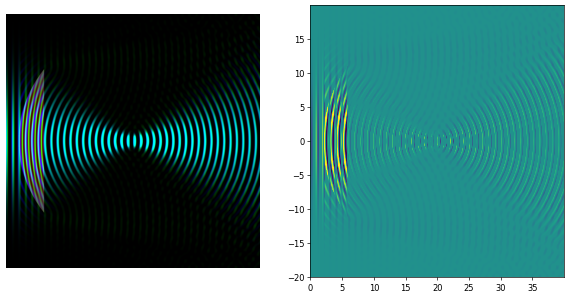

In [58]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 6),dpi=60)

br=1.0 
bg=1.0 
bb=1.0 

R=np.clip(br*R,0.0,1.0)
G=np.clip(bg*G,0.0,1.0)
B=np.clip(bb*B,0.0,1.0)
RGB=np.dstack((np.flipud(R.T), np.flipud(G.T), np.flipud(B.T))) # use transpose to swap image axes, flipud to origin at bottom left

ax1.imshow(RGB)#12
ax1.set_axis_off()

# optional subplot to check whether we have done axis scaling correctly
ax2.pcolormesh(Z,Y,B-G)